# Transports Through Straits

Computing the depth-integrated volume transport through some major straits.

## Theory

Formally, mass transports are given by

$$T_x = \rho u  $$
$$T_y = \rho v  $$

Mass transports are diagnostics that are calculated online by the model:

| variable|long name|units|dimensions|
| --- |  --- | --- | --- |
| `tx_trans` |T-cell i-mass transport|Sv|(time,st_ocean,xu_ocean,yt_ocean)|
| `ty_trans` |T-cell j-mass transport|Sv|(time,st_ocean,xt_ocean,yu_ocean)|


Variable `tx_trans` contains the instantaneous zonal transport multiplied with $y$-$z$ face of the volume of each cell:
    <center> `tx_trans`$=T_{x}(x, y, z, t)\,\Delta y\,\Delta z$.</center>

Similarly, `tx_trans` contains
    <center> `ty_trans`$=T_{y}(x, y, z, t)\,\Delta x\,\Delta z$.</center>
    
Thus, `tx_trans` and `ty_trans` variables come in units of $\underbrace{kg\,m^{-3}}_{\rm density} \times \underbrace{m\,s^{-1}}_{\rm velocity}\times\underbrace{m^2}_{\rm area} = kg\,s^{-1}$. To get the volume transport ($m^3\,s^{-1}$) we have to divide by $\rho$.

## Calculation

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import cosima_cookbook as cc
import matplotlib.pyplot as plt

from dask.distributed import Client

Load a `dask` client.

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:43263 Dashboard: /proxy/8787/status,Cluster Workers: 8 Cores: 48 Memory: 202.49 GB


Use default database for this calculation

In [3]:
session = cc.database.create_session()

This dictionary defines a few key choke points that you might be interested in. For the purposes of demonstration we are just using Drake Passage in this example.

In [4]:
straits = { 'DrakePassage': [-69.9, -69.9, -71.6, -51.0],
              'Lombok':     [-244.6+360, -243.9+360, -8.6, -8.6],
              'Ombai' :     [-235.0+360, -235.0+360, -9.2, -8.1],
              'Timor' :     [-235.9+360, -235.9+360, -11.9, -9.9],
              'Bering' :    [-172, -167, 65.8, 65.8],
              'Denmark' :   [-42, -22, 65.8, 65.8],
            }

Here we define a function so that you can specify a given strait, and rely on the function to extract the transport through that strait.

In [5]:
rho = 1036 # kg/m^3, mean density of seawater

def calc_transport(expt, strait):
    """
    Calculate barotropic transport across a given 
     line of latitude or longitude.
     
    Designed for flow through straits.
    """
    
    xmin, xmax, ymin, ymax = straits[strait]
    
    if ymax>=65:
        raise ValueError('North of 65N the tripolar grid geometry brings complications and `.sum(''xt_ocean'')` is wrong!')
    
    print('Calculating {}:{} transport'.format(expt, strait))
    
    if xmin == xmax:                
        tx_trans = cc.querying.getvar(expt,'tx_trans',session)
        transport = tx_trans.sel(xu_ocean=xmin, method='nearest')\
                            .sel(yt_ocean=slice(ymin, ymax))\
                            .sum('st_ocean').sum('yt_ocean')/rho/1e6 #divide by ρ to convert to volume transport, m^3/s, and with 1e6 to convert to Sv.

    elif ymin == ymax:
        ty_trans = cc.querying.getvar(expt,'ty_trans',session)
        transport = ty_trans.sel(yu_ocean=ymin, method='nearest')\
                            .sel(xt_ocean=slice(xmin, xmax))\
                            .sum('st_ocean').sum('xt_ocean')/rho/1e6 #divide by ρ to convert to volume transport, m^3/s, and with 1e6 to convert to Sv.
    else:
        raise ValueError('Transports are computed only along lines of either constant latitude or longitude')
    
    transport = transport.compute()
       
    return transport

Now, for a given experiment, calculate the total (barotropic) transport through Drake Passage:

In [6]:
%%time
expt = '025deg_jra55v13_ryf9091_gmredi6'
transport = calc_transport(expt, 'DrakePassage')

Calculating 025deg_jra55v13_ryf9091_gmredi6:DrakePassage transport
CPU times: user 15.5 s, sys: 738 ms, total: 16.3 s
Wall time: 23.2 s


Plot the result

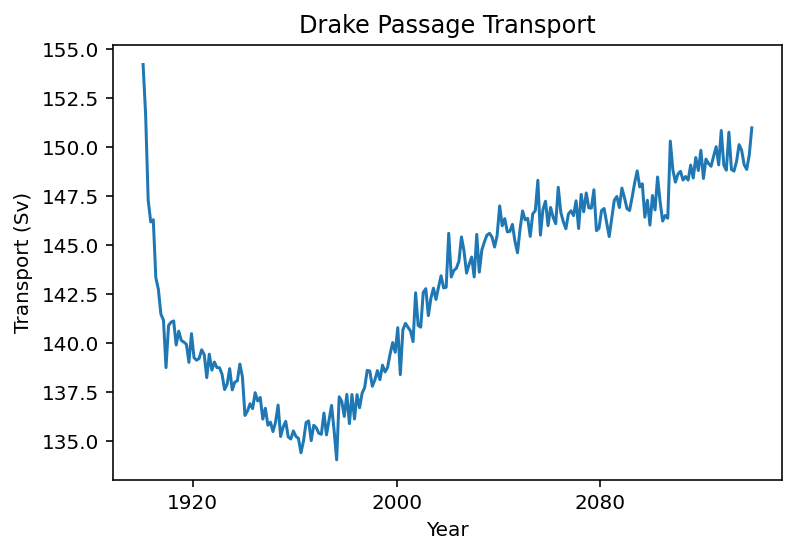

In [7]:
transport.plot(linestyle='-')
plt.title('Drake Passage Transport')
plt.xlabel('Year')
plt.ylabel('Transport (Sv)');